# Détectez les bad buzz grace au Deeplearning

In [44]:
import warnings
warnings.simplefilter(action='ignore')
# basic libs
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import unidecode
import gc
from io import StringIO
# text preprocessing
import nltk
import gensim
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
# simple random forest regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# deeplearning
import tensorflow as tf
# azure
import requests
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


In [54]:
def standardize(text):
        text = unidecode.unidecode(text.replace('\n', ' '))
        for exclude in ['&quot;', '&amp;']:
            text = text.replace(exclude, '')
        text = text.split()
        for exclude in ['@', '/']:
            text = [w for w in text if not exclude in w]
        text = ' '.join(text)
        return text if any([c.isalpha() for c in text]) else ''
    
def update_target(tgt):
        return 1 if tgt else 0
    
def make_short_df(nr):
    df = pd.read_csv('./data/dataset.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')
    df = df.sample(frac=1)
    df["text"] = df["text"].apply(standardize)
    df = df[df['text'] != ""]
    df = df.head(nr)

    df["target"] = df["target"].apply(update_target)
    df = df[['target', 'text']]
    df.to_csv("short_df.csv", index=False)

# make_short_df(1000)

### Text preproccessing

On commence par tokéniser le texte (on ne garde que les mots, en supprimant la pontuation, les liens, les nombres ...).
On retire également les "stop-words", c'est-à-dire tous les articles, déterminants, pronoms et mots de liaison.
On applique ensuite deux traitements différents séparément pour comparer leurs performances: la lemmatisation (qui garde seulement la forme canonique des mots, par exemple le féminin singulier) et le stemming (qui garde uniquement le radical des mots). 

In [4]:
done_preprocessing = 1

n_words = 25000 # warning: must be higher than 5k later

test_size = 100000
val_size = 100000

lbls = ['Negative', '', '', '', 'Positive']

if not done_preprocessing:
    train_df = pd.read_csv('./data/dataset.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')
    train_df = train_df[['target', 'text']]
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stop_words = list(nltk.corpus.stopwords.words('english'))
    
    def clean_up(text):
        text = unidecode.unidecode(''.join(c for c in text if not c.isdigit()).replace('\n', '').lower())
        for exclude in ['&quot;', '&amp;']:
            text = text.replace(exclude, '')
        text = text.split()
        for exclude in ['@', '/']:
            text = [w for w in text if not exclude in w]
        text = ' '.join(text)
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if not w in stop_words and len(w) > 1]
        tokens = ' '.join(tokens)
        return tokens if any([c.isalpha() for c in tokens]) else ''
    
    train_df["text"] = train_df["text"].apply(clean_up)
    
    train_df = train_df[train_df['text'] != ""]
    
    train_df["target"] = train_df["target"].apply(update_target)
    
    train_df = train_df.sample(frac=1)
    
    train_df.to_csv('./data/preprocessed.csv', index=False)

In [5]:
if not done_preprocessing:
    
    train_df = pd.read_csv('./data/preprocessed.csv')
    
    stemmer = EnglishStemmer()
    lemmatizer = WordNetLemmatizer()

    def stem(text):
        return [w for w in [stemmer.stem(w2) for w2 in text]if len(w) > 1]

    def lem(text):
        return [w for w in [lemmatizer.lemmatize(w2) for w2 in text]if len(w) > 1]
    
    # vanilla
    train_df["text"] = train_df["text"].apply(lambda x: x.split())
    v_dictionary = gensim.corpora.Dictionary(train_df["text"].tolist())
    print(f"Found {len(v_dictionary)} unique tokens in vanilla text")
    v_dictionary.filter_extremes(no_below=20, no_above=0.8, keep_n=n_words)
    v_words = v_dictionary.token2id
    with open(f"./data/vanilla_vocab_{n_words}.txt", "w") as f:
        for w in v_words:
            f.write(w)
            f.write('\n')
            
    # stemming
    train_df["text_stem"] = train_df["text"].apply(stem)
    s_dictionary = gensim.corpora.Dictionary(train_df["text_stem"].tolist())
    print(f"Found {len(s_dictionary)} unique tokens after stemming")
    s_dictionary.filter_extremes(no_below=20, no_above=0.8, keep_n=n_words)
    s_words = s_dictionary.token2id
    with open(f"./data/stemming_vocab_{n_words}.txt", "w") as f:
        for w in s_words:
            f.write(w)
            f.write('\n')
    
    # lemmatization
    train_df["text_lem"] = train_df["text"].apply(lem)
    l_dictionary = gensim.corpora.Dictionary(train_df["text_lem"].tolist())
    print(f"Found {len(l_dictionary)} unique tokens after lemmatisation")
    l_dictionary.filter_extremes(no_below=20, no_above=0.8, keep_n=n_words)
    l_words = l_dictionary.token2id
    with open(f"./data/lemmatization_vocab_{n_words}.txt", "w") as f:
        for w in l_words:
            f.write(w)
            f.write('\n')
    
    def clean_vanilla(tokens):
        return " ".join([t for t in tokens if t in v_words])
    
    def clean_stem(tokens):
        return " ".join([t for t in tokens if t in s_words])
        
    def clean_lem(tokens):
        return " ".join([t for t in tokens if t in l_words])

    # clean new df
    train_df["text"] = train_df["text"].apply(clean_vanilla)
    train_df["text_stem"] = train_df["text_stem"].apply(clean_stem)
    train_df["text_lem"] = train_df["text_lem"].apply(clean_lem)

    train_df = train_df[train_df['text'] != ""]
    train_df = train_df[train_df['text_stem'] != ""]
    train_df = train_df[train_df['text_lem'] != ""]
    
    train_df = train_df.sample(frac=1)
    
    print(f"Final dataframe size: {train_df.shape[0]}")
    
    # make train test split
    test_df = train_df.head(test_size)
    train_df = train_df.tail(train_df.shape[0] - test_size)
    val_df = train_df.head(val_size)
    train_df = train_df.tail(train_df.shape[0] - val_size)
    test_df.to_csv(f'./data/text_test_{n_words}.csv', index=False)
    val_df.to_csv(f'./data/text_val_{n_words}.csv', index=False)
    train_df.to_csv(f'./data/text_train_{n_words}.csv', index=False)
else:
    print("Found 270425 unique tokens in vanilla text\nFound 223960 unique tokens after stemming\nFound 258567 unique tokens after lemmatisation\nFinal dataframe size: 1577584")

Found 270425 unique tokens in vanilla text
Found 223960 unique tokens after stemming
Found 258567 unique tokens after lemmatisation
Final dataframe size: 1577584


In [6]:
if done_preprocessing:
    train_df = pd.read_csv(f'./data/text_train_{n_words}.csv')
    train_df = train_df.dropna()
    test_df = pd.read_csv(f'./data/text_test_{n_words}.csv')
    test_df = test_df.dropna()
    val_df = pd.read_csv(f'./data/text_val_{n_words}.csv')
    val_df = val_df.dropna()
    
train_df.head()

,target,text,text_stem,text_lem
0,1,know would hold door open going somewhere toge...,know would hold door open go somewher togeth,know would hold door open going somewhere toge...
1,1,lol hav dell desktop mini,lol hav dell desktop mini,lol hav dell desktop mini
2,1,yum bake something come bring,yum bake someth come bring,yum bake something come bring
3,1,dont worry make,dont worri make,dont worry make
4,1,lady thanks things little weird right send epi...,ladi thank thing littl weird right send epic e...,lady thanks thing little weird right send epic...


In [7]:
results_file = f'./results.csv'

if not os.path.isfile(results_file):
    results = pd.DataFrame(columns=['model_name', 'accuracy', 'loss'])
    results.to_csv(results_file, index=False)

def add_result(name, accuracy, loss=None):
    result_df = pd.read_csv(results_file)
    result_df = result_df[result_df["model_name"] != name]
    result_df = result_df.append({"model_name": name, "accuracy": accuracy, "loss": loss}, ignore_index=True)
    result_df.to_csv(results_file, index=False)
    
def get_results():
    result_df = pd.read_csv(results_file)
    print(result_df.head(20))

### Baseline

Le modèle de base servant de références aux autres modèles est une simple régression (random forest) appliquée sur les bag-of-words.

In [8]:
trained = 1

debug = 0

if debug:
    train_df = train_df.head(500000) # 20000 => 5Go for random forest & simple models with 5K vocabulary
    val_df = val_df.head(5000)
    test_df = test_df.head(5000)

In [9]:
if not trained:
    vanilla_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized = vanilla_vectoriser.fit_transform(train_df["text"].to_list()).toarray()
    test_vectorized = vanilla_vectoriser.transform(test_df["text"].to_list()).toarray()

    stem_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized_stem = stem_vectoriser.fit_transform(train_df["text_stem"].to_list()).toarray()
    test_vectorized_stem = stem_vectoriser.transform(test_df["text_stem"].to_list()).toarray()

    lem_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized_lem = lem_vectoriser.fit_transform(train_df["text_lem"].to_list()).toarray()
    test_vectorized_lem = lem_vectoriser.transform(test_df["text_lem"].to_list()).toarray()

    target = train_df["target"].to_list()
    test_target = test_df["target"].to_list()

#### Vanilla

In [10]:
if not debug and not trained:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [11]:
if not trained:
    random_forest = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest.fit(train_vectorized, target)
    joblib.dump(random_forest, "./models/random_forest.joblib")
    
    perf = random_forest.score(test_vectorized, test_target)
    add_result("random_forest", perf)
    
    del random_forest
    gc.collect()

#### Avec stemming

In [12]:
if not debug and not trained:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized_stem, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [13]:
if not trained:
    random_forest_stem = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest_stem.fit(train_vectorized_stem, target)
    joblib.dump(random_forest_stem, "./models/random_forest_stem.joblib")
    
    perf = random_forest_stem.score(test_vectorized_stem, test_target)
    add_result("random_forest_stem", perf)

    del random_forest_stem
    gc.collect()

#### Avec lemmatization

In [14]:
if not debug and not trained:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized_lem, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [15]:
if not trained:
    random_forest_lem = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest_lem.fit(train_vectorized_lem, target)
    
    perf = random_forest_lem.score(test_vectorized_lem, test_target)
    add_result("random_forest_lem", perf)
    
    joblib.dump(random_forest_lem, "./models/random_forest_lem.joblib")
    
    del random_forest_lem
    gc.collect()
    

### Deeplearning

In [16]:
batch_size = 10

BUFFER_SIZE = 1000

AUTOTUNE = tf.data.AUTOTUNE

n_epochs = 10

data_passes = 2

steps_per_epoch = (train_df.shape[0] * data_passes) // (batch_size * n_epochs)

def process_model(model, hist, name, test_dataset):
    # get results
    history = pd.DataFrame(data=hist.history)
    model_performance = model.evaluate(test_dataset)
    model_pred = model.predict(test_dataset)
    test_df[f"{name}_label"] = model_pred
    # save results
    model.save(f"./models/{name}.h5")
    history.to_csv(f'./models/{name}_history.csv', index=False)
    model.save_weights(f'./models/{name}_weights.h5')
    add_result(name, model_performance[1], model_performance[0])
    test_df.to_csv('./labels_df.csv', index=False)


def display_learning_curves(hst):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.show()

In [17]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

vocab_vanilla = load_doc(f"./data/vanilla_vocab_{n_words}.txt")
vocab_vanilla = vocab_vanilla.split()
vocab_vanilla = set(vocab_vanilla)
vocab_stem = load_doc(f"./data/stemming_vocab_{n_words}.txt")
vocab_stem = vocab_stem.split()
vocab_stem = set(vocab_stem)
vocab_lem = load_doc(f"./data/lemmatization_vocab_{n_words}.txt")
vocab_lem = vocab_lem.split()
vocab_lem = set(vocab_lem)


In [18]:
# get targets
y_train = np.asarray(train_df["target"].to_list())
y_test = np.asarray(test_df["target"].to_list())
y_val = np.asarray(val_df["target"].to_list())

#### Modèles simples

In [19]:
def train_simple_nn(train_dataset, test_dataset, validation_dataset, name, has_trained=0):
    # vectorize data
    if has_trained:
        vectoriser = joblib.load(f"./models/{name}_vectoriser.joblib")
        train_vectorized = vectoriser.transform(train_dataset).toarray()
        test_vectorized = vectoriser.transform(test_dataset).toarray()
        val_vectorized = vectoriser.transform(validation_dataset).toarray()
    else:
        vectoriser = CountVectorizer(max_features=n_words)
        train_vectorized = vectoriser.fit_transform(train_dataset).toarray()
        test_vectorized = vectoriser.transform(test_dataset).toarray()
        val_vectorized = vectoriser.transform(validation_dataset).toarray()
        joblib.dump(vectoriser, f"./models/{name}_vectoriser.joblib")
     # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(train_vectorized), tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(test_vectorized), tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((np.asarray(val_vectorized), tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
    # build model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, input_dim=np.shape(train_vectorized)[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    if has_trained:
        model.load_weights(f'./models/{name}.h5')
        history = pd.read_csv(f'./models/{name}_history.csv')

    print(model.summary())
    
    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])
    # train model
    hist = model.fit(train_ds,
                     epochs=n_epochs,
                     verbose=2,
                     validation_data=val_ds,
                     batch_size=batch_size,
                     steps_per_epoch=steps_per_epoch)
    
    process_model(model, hist, name, test_ds)
    
    # cleaning
    del train_ds
    del test_ds
    del val_ds
    gc.collect()
    

##### Vanilla

In [20]:
model_name = "vanilla_nn"
# train_simple_nn(train_df["text"].to_list(), test_df["text"].to_list(), val_df["text"].to_list(), model_name)

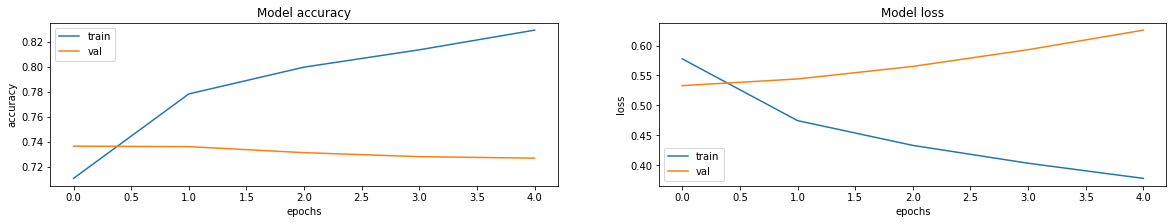

In [21]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Stemming

In [22]:
model_name = "stemming_nn"
# train_simple_nn(train_df["text_stem"].to_list(), test_df["text_stem"].to_list(), val_df["text_stem"].to_list(), model_name)

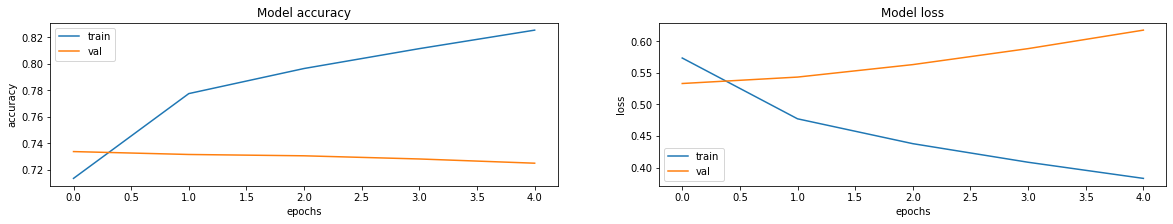

In [23]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Lemmatization

In [24]:
model_name = "lemmatization_nn"
# train_simple_nn(train_df["text_lem"].to_list(), test_df["text_lem"].to_list(), val_df["text_lem"].to_list(), model_name)

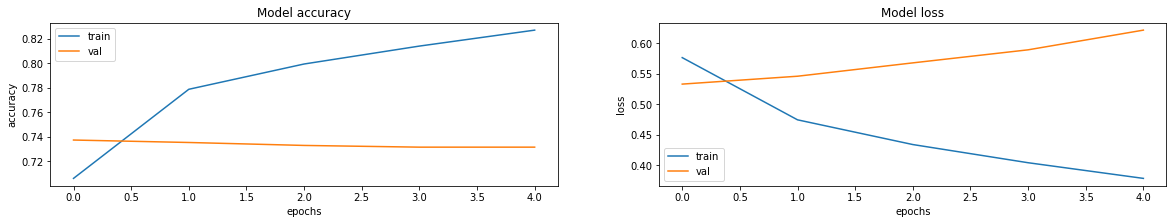

In [25]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

<AxesSubplot:xlabel='target', ylabel='Count'>

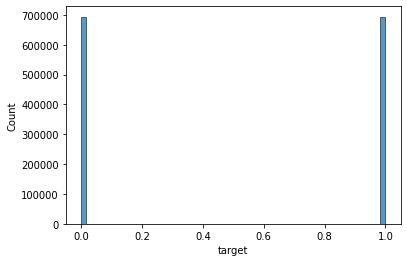

In [26]:
sns.histplot(data=train_df["target"])

#### Utilisation de modèles de plongement de mots

In [27]:
trained = 0

if not trained:
    # get train data
    X_train = train_df["text"].to_list()
    # X_train_stem = train_df["text_stem"].to_list()
    # X_train_lem = train_df["text_lem"].to_list()
    
    # get test data
    X_test = test_df["text"].to_list()
    # X_test_stem = test_df["text_stem"].to_list()
    # X_test_lem = test_df["text_lem"].to_list()
    
    # get validation data
    X_val = val_df["text"].to_list()
    # X_val_stem = val_df["text_stem"].to_list()
    # X_val_lem = val_df["text_lem"].to_list()
    def encoder(data_train, data_test, data_val):
        # tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words)
        # tokenizer.fit_on_texts(data_train)
        tokenizer = joblib.load(f"./azure/tokenizer.joblib")
        
        encoded_train = tokenizer.texts_to_sequences(data_train)
        encoded_test = tokenizer.texts_to_sequences(data_test)
        encoded_val = tokenizer.texts_to_sequences(data_val)
        max_len = max([len(s.split()) for s in data_train])
        train_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=max_len, padding='post'))
        test_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=max_len, padding='post'))
        val_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_val, maxlen=max_len, padding='post'))

        return train_data, test_data, val_data, max_len, tokenizer

    X_train, X_test, X_val, vanilla_input_dim, vanilla_tokenizer = encoder(X_train, X_test, X_val)
    # X_train_stem, X_test_stem, X_val_stem, stem_input_dim, stem_tokenizer = encoder(X_train_stem, X_test_stem, X_val_stem)
    # X_train_lem, X_test_lem, X_val_lem, lem_input_dim, lem_tokenizer = encoder(X_train_lem, X_test_lem, X_val_lem)
    
    # joblib.dump(vanilla_tokenizer, "./azure/tokenizer.joblib")
    
    # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
    
    print(f"Sequences encoded on {vanilla_input_dim} words")
    

Sequences encoded on 86 words


##### Glove

In [28]:
glove_dim = 200

In [29]:
def load_embedding(filename):
    file = open(filename, encoding="utf8")
    lines = file.readlines()
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding
 
def get_weight_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, glove_dim))
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

vocab_size = len(vanilla_tokenizer.word_index) + 1
raw_embedding = load_embedding(f'./models/glove.6B.{glove_dim}d.txt')
embedding_vectors = get_weight_matrix(raw_embedding, vanilla_tokenizer.word_index)
embedding_layer = tf.keras.layers.Embedding(vocab_size, glove_dim, weights=[embedding_vectors], input_length=vanilla_input_dim, trainable=True)

In [30]:
model_name = "glove_cnn"

def train_glove_model(has_trained=0):

    glove_model = tf.keras.models.Sequential()
    glove_model.add(embedding_layer)
    glove_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    glove_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    glove_model.add(tf.keras.layers.Flatten())
    glove_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    print(glove_model.summary())
    
    glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = glove_model.fit(train_ds,
                           epochs=n_epochs,
                           verbose=2,
                           validation_data=val_ds,
                           batch_size=batch_size,
                           steps_per_epoch=steps_per_epoch)
    
    process_model(glove_model, hist, model_name, test_ds)

train_glove_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 86, 200)           4315000   
_________________________________________________________________
conv1d (Conv1D)              (None, 82, 128)           128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 41, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5248)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5249      
Total params: 4,448,377
Trainable params: 4,448,377
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
27729/27729 - 208s - loss: 0.4925 - accuracy: 0.7633 - val_loss: 0.4771 - val_accuracy: 0.7734
E

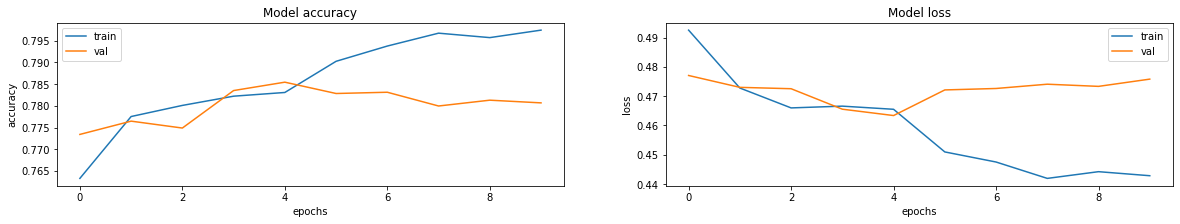

In [31]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Glove + LSTM

In [32]:
model_name = "glove_lstm_nn"

def train_glove_lstm_model(has_trained=0):
    
    glove_model = tf.keras.models.Sequential()
    glove_model.add(embedding_layer) 
    glove_model.add(tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.2))
    glove_model.add(tf.keras.layers.GlobalMaxPooling1D())
    glove_model.add(tf.keras.layers.Dense(64,activation='relu')) 
    glove_model.add(tf.keras.layers.Dense(1,activation='sigmoid')) 

    print(glove_model.summary())
    
    glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    hist = glove_model.fit(train_ds,
                           epochs=n_epochs,
                           verbose=2,
                           validation_data=val_ds,
                           batch_size=batch_size,
                           steps_per_epoch=steps_per_epoch)
    
    process_model(glove_model, hist, model_name, test_ds)

train_glove_lstm_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 86, 200)           4315000   
_________________________________________________________________
lstm (LSTM)                  (None, 86, 128)           168448    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,491,769
Trainable params: 4,491,769
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
27729/27729 - 303s - loss: 0.4403 - accuracy: 0.7948 - val_loss: 0.4529 - val_accuracy: 0.7905

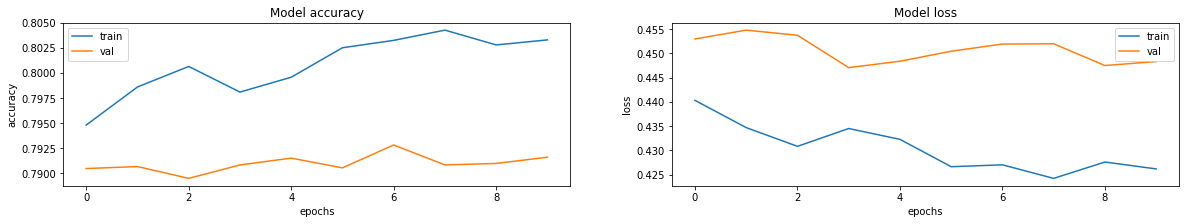

In [33]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Word2vec

In [34]:
# word2vec_pretrained = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)

In [35]:
get_results()

           model_name  accuracy      loss
0       random_forest   0.72180       NaN
1  random_forest_stem   0.72620       NaN
2   random_forest_lem   0.71880       NaN
3          vanilla_nn   0.72840  0.617380
4         stemming_nn   0.73520  0.611000
5    lemmatization_nn   0.73180  0.617316
6           glove_cnn   0.78037  0.475773
7       glove_lstm_nn   0.79176  0.448903


### Azure

#### Requêtes au modèle déployé

In [20]:
def parse_resp(resp):
    return [float(r[1:-1])for r in resp[1:-1].split(', ')]

with open('./azure/azure_uri.txt', 'r') as f:
    scoring_uri = f.readline()

with open('./short_df.csv', 'r') as f:
    input_data = f.read()

headers = {'Content-Type': 'application/json'}

resp = requests.post(scoring_uri, input_data, headers=headers)

print("POST to url", scoring_uri)

print("prediction:", parse_resp(resp.text))



POST to url http://5c6e8f0a-1c00-4a84-a475-3fc374966565.francecentral.azurecontainer.io/score
prediction: [0.9187076091766357, 0.8008436560630798, 0.6348123550415039, 0.22918838262557983, 0.041091978549957275, 0.012520551681518555, 0.03288605809211731, 0.04638776183128357, 0.15394681692123413, 0.6660974025726318]


#### Requêtes à l'API Cognitive Services Text Analytics

In [57]:
n_sample = 500

with open(f'./azure/ASTA_key.txt', 'r') as f:
    key = f.readline()
        
with open(f'./azure/ASTA_endpoint.txt', 'r') as f:
    endpoint = f.readline()

def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [58]:
def sentiment_analysis_output(client, documents):
    for response in client.analyze_sentiment(documents=documents):
        print("Document Sentiment: {}".format(response.sentiment))
        print("Overall scores: positive={0:.2f}; neutral={1:.2f}; negative={2:.2f} \n".format(
            response.confidence_scores.positive,
            response.confidence_scores.neutral,
            response.confidence_scores.negative,
        ))
        for idx, sentence in enumerate(response.sentences):
            print("Sentence: {}".format(sentence.text))
            print("Sentence {} sentiment: {}".format(idx+1, sentence.sentiment))
            print("Sentence score:\nPositive={0:.2f}\nNeutral={1:.2f}\nNegative={2:.2f}\n".format(
                sentence.confidence_scores.positive,
                sentence.confidence_scores.neutral,
                sentence.confidence_scores.negative,
            ))
            
def sentiment_analysis_score(client, documents):
    pred_labels = []
    for response in client.analyze_sentiment(documents=documents):
        pos = response.confidence_scores.positive
        neg = response.confidence_scores.negative
        neu = response.confidence_scores.neutral
        s = pos + neg
        if s:
            pred_labels += [pos / s > .5]
        else:
            pred_labels += [1]
    return pred_labels
    

In [59]:
example_df = pd.read_csv('./short_df.csv')

example_df = example_df.head(n_sample)

docs = example_df["text"].tolist()

lbls = example_df["target"].tolist()

example_df.head(n_sample)

,target,text
0,1,it's not too far from Milford which has a lot of stores a big mall
1,1,Just woke up. Under solo and bar solo was really good last night
2,0,You're still not following me and my feelings are hurt.
3,1,I'm still sipping wines with Archie and Howard
4,1,tonight i paint...screenprint and plan. the working night begins here!
5,0,"still awake, with one hour left before getting up to go to work. I can foresee already a long and miserable day ahead of me."
6,1,i got my necklace and eyeko lip balm from asos today happy bunny
7,0,Probably need your brolly Ian we have rain to the south of us heading up this way
8,1,"the day after.... I`m not sick but a little tierd...a bit to much to drink, but I had fun!"
9,1,yaeah i heard the news..just check the website..mau sihh..tapi kudu nabung btw kmrn ikut video:wrk surabaya


In [60]:
pred_lbls = []
for i in range(10, n_sample + 1, 10):
    pred_lbls.extend(sentiment_analysis_score(client, docs[i-10:i]))

In [62]:
pred_lbls.extend(sentiment_analysis_score(client, docs[490:500]))

In [63]:
# Comme la variable cible du jeu de données est balancée, on évalue l'accuracy du modèle
acc = accuracy_score(lbls, pred_lbls)
print(f"Accuracy: {acc}")

Accuracy: 0.726


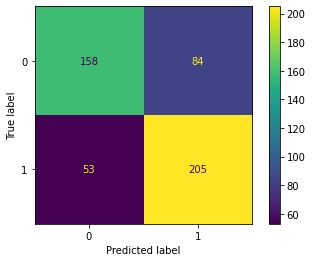

In [64]:
# On affiche la matrice de confusion
cm = confusion_matrix(lbls, pred_lbls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [66]:
example_df["ASTA_pred"] = pred_lbls
example_df.to_csv("short_df.csv", index=False)
example_df.head()

,target,text,ASTA_pred
0,1,it's not too far from Milford which has a lot of stores a big mall,False
1,1,Just woke up. Under solo and bar solo was really good last night,True
2,0,You're still not following me and my feelings are hurt.,False
3,1,I'm still sipping wines with Archie and Howard,True
4,1,tonight i paint...screenprint and plan. the working night begins here!,True
